In [1]:
from __future__ import print_function
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# HW 6:  ODE Methods - Boundary Value Problems

This homework will combine a lot of previous codes to solve simple linear and non-linear Boundary value problems

This problem set has two questions

## Question 1 - A linear ODE BVP

Consider the *linear* non-homogeneous 2-pt boundary value problem

$$
    u^{\prime\prime}+ u = \sin3x\quad\quad x\in[0,L],\quad u(0)=u(L)=0
$$

which is related to the modes of vibration of a forced string of length $L$.

**(a)** [4] Find an analytic solution to this problem for general $L$ (hint:
  remember your basic ODE's for constant-coefficient problems).  Is
  this solution unique?

n
# Analytic Solution to the BVP

The problem:
$$
u^{\prime\prime} + u = \sin(3x), \quad x \in [0, L], \quad u(0) = u(L) = 0.
$$

### Steps to Solve

1. **Solve the Homogeneous Equation:**
   The homogeneous equation is:
   $$
   u_h^{\prime\prime} + u_h = 0.
   $$
   The characteristic equation is:
   $$
   r^2 + 1 = 0 \implies r = \pm i.
   $$
   The general solution to the homogeneous equation is:
   $$
   u_h(x) = C_1\cos(x) + C_2\sin(x).
   $$

2. **Find a Particular Solution:**
   For the non-homogeneous equation \( u^{\prime\prime} + u = \sin(3x) \), assume:
   $$
   u_p(x) = A\cos(3x) + B\sin(3x).
   $$
   Substituting into the original equation and equating coefficients, we find:
   $$
   A = 0, \quad B = -\frac{1}{8}.
   $$
   Thus, the particular solution is:
   $$
   u_p(x) = -\frac{1}{8}\sin(3x).
   $$

3. **Combine the General and Particular Solutions:**
   The general solution to the equation is:
   $$
   u(x) = u_h(x) + u_p(x) = C_1\cos(x) + C_2\sin(x) - \frac{1}{8}\sin(3x).
   $$

4. **Apply the Boundary Conditions:**

   - At \( x = 0 \), \( u(0) = 0 \):
     $$
     C_1\cos(0) + C_2\sin(0) - \frac{1}{8}\sin(3 \cdot 0) = 0 \implies C_1 = 0.
     $$
   - At \( x = L \), \( u(L) = 0 \):
     $$
     C_2\sin(L) - \frac{1}{8}\sin(3L) = 0 \implies C_2\sin(L) = \frac{1}{8}\sin(3L).
     $$
     If \( \sin(L) \neq 0 \):
     $$
     C_2 = \frac{\sin(3L)}{8\sin(L)}.
     $$

5. **Final Solution:**
   $$
   u(x) = \frac{\sin(3L)}{8\sin(L)}\sin(x) - \frac{1}{8}\sin(3x).
   $$

6. **Uniqueness:**
   The solution is unique because the problem is a second-order linear differential equation with two boundary conditions, which uniquely determines the solution.
```

The uniqueness of the solution arises from the following principles:

1. **Linearity of the ODE**: The equation 
   $u'' + u = \sin(3x)$ 
   is a linear differential equation. Linearity ensures that any two solutions differ by only a solution to the corresponding homogeneous equation, and the boundary conditions eliminate this ambiguity.

2. **Fixed Boundary Conditions**: The boundary conditions 
   $$u(0) = 0 \quad \text{and} \quad u(L) = 0$$ 
   are specific and sufficient to uniquely determine the constants of integration $A$ and $B$.

3. **Uniqueness Theorem for Second-Order Linear ODEs**: This theorem states that a second-order linear ODE with continuous coefficients, coupled with fixed boundary values, has a unique solution. The coefficients in this case ($1$ for $u$ and $1$ for $u''$) are constants, satisfying the conditions of the theorem.

Thus, there exists a unique solution to this boundary value problem for any given $L$.


**(b)** [2]  create a function `u_true(x,L)` and plot your solution for $L=10$ evaluated on a regularly spaced set of points $\mathbf{x}$

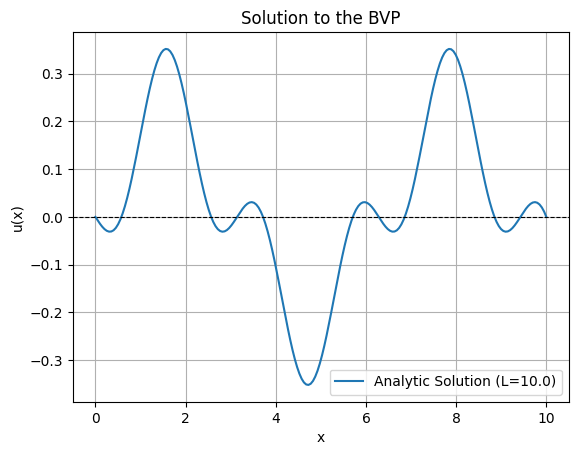

In [8]:

import numpy as np
import matplotlib.pyplot as plt

def u_true(x, L):
    if np.isclose(np.sin(L), 0):
        raise ValueError("sin(L) cannot be zero for this solution.")
    C2 = np.sin(3 * L) / (8 * np.sin(L))
    return C2 * np.sin(x) - (1 / 8) * np.sin(3 * x)

L = 10.0
N = 200
x = np.linspace(0., L, N)  

u = u_true(x, L)

plt.plot(x, u, label=f"Analytic Solution (L={L})")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("Solution to the BVP")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--') 
plt.legend()
plt.grid()
plt.show()


**(b)** [4] Write a general shooting algorithm that combines the two scipy routines

* scipy.integrate.solve_ivp
* scipy.optimized.root_scalar

and returns the solution evaluated at an evenly spaced set of points $\mathbf{x}$.  

Some hints

* use `dense_output = True` in solve_ivp
* you can introduce a second def within shoot_bvp for use in root_scalar

For convenience (and testing), I've provided the interface introduced in class for a routine that can handle a range of boundary conditions and can control relative and absolute tolerance.

In [10]:
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

def shoot_bvp(f, x, u_a, u_b, i_a, i_b, rtol=1.e-7, atol=1.e-9):
    r"""
    Solve the two-point boundary value problem on the interval \(x \in [a,b]\), using a shooting method that combines 
        scipy.integrate.solve_ivp and scipy.optimize.root_scalar and allows a range of boundary conditions
        
    Parameters:
    -----------
    f : callable
        Vector-valued function for the right-hand side of the ODE with interface f(t,u), returning an ndarray of length 2.
    x : numpy array
        Coordinates array for the solution on the interval [a,b], with x[0] = a and x[-1] = b.
    u_a : numpy array (length 2)
        Initial boundary conditions [u, u'] at x = a.
    u_b : numpy array (length 2)
        Target boundary condition at x = b.
    i_a : int
        Index of the known boundary condition at x = a:
        - 0 for Dirichlet (u(a) is known)
        - 1 for Neumann (u'(a) is known)
    i_b : int
        Index of the known boundary condition at x = b:
        - 0 for Dirichlet (u(b) is known)
        - 1 for Neumann (u'(b) is known)
    rtol : float
        Relative tolerance.
    atol : float
        Absolute tolerance.
        
    Returns:
    --------
    u : numpy array
        Solution u(x) for x (uses dense_output from solve_ivp to interpolate the solution onto x).
    """
    
    def mismatch(s):
        if i_a == 0:
            u0 = u_a[0]
            du0 = s
        elif i_a == 1:
            du0 = u_a[1]
            u0 = 0
        sol = solve_ivp(f, [x[0], x[-1]], [u0, du0], t_eval=x, rtol=rtol, atol=atol, dense_output=True)
        if i_b == 0:
            return sol.y[0, -1] - u_b[0]
        elif i_b == 1:
            return sol.y[1, -1] - u_b[1]
    
    root_res = root_scalar(mismatch, bracket=[-1e2, 1e2], method='bisect', xtol=1e-6)
    
    # if not root_res.success:
    #     raise RuntimeError("Shooting method failed to converge")
    
    optimal_slope = root_res.root
    
    if i_a == 0:
        u0 = u_a[0]
        du0 = optimal_slope
    elif i_a == 1:
        du0 = u_a[1]
        u0 = 0

    sol = solve_ivp(f, [x[0], x[-1]], [u0, du0], t_eval=x, rtol=rtol, atol=atol, dense_output=True)

    return sol.y[0, :], sol.y[1, :]


**(c)** [4] rewrite the original problem 

$$
    u^{\prime\prime} + u = \sin(3x)
$$

as a system of first order ODE's

$$
    \frac{d\mathbf{v}}{dx} = \mathbf{f}(x,\mathbf{v})
$$  

and solve using the interface

`u_sol = shoot_bvp(f, x, u_a, u_b, i_a, i_b)`

* make a plot comparing your shooting solution with the true solution.

### Rewrite as a First-Order System of ODEs

The second-order ODE is given as:

$$
u^{\prime\prime} + u = \sin(3x).
$$

To convert this into a system of first-order ODEs, we introduce two new variables:
- Let $v_1 = u$ (the function itself),
- Let $v_2 = u'$ (the first derivative of $u$).

Then:

1. $ v_1^\prime = u^\prime = v_2 $,
2. $ v_2^\prime = u^{\prime\prime} = \sin(3x) - u = \sin(3x) - v_1 $.
   
Now, we can express the system as:

$$
\frac{d}{dx}
\begin{bmatrix}
v_1 \\ 
v_2
\end{bmatrix}
=
\begin{bmatrix}
v_2 \\ 
\sin(3x) - v_1
\end{bmatrix}.
$$

This system is now in the form of a first-order system:

$$
\frac{d\mathbf{v}}{dx} = \mathbf{f}(x, \mathbf{v}),
$$

where:

$$
\mathbf{f}(x, \mathbf{v}) =
\begin{bmatrix}
v_2 \\ 
\sin(3x) - v_1
\end{bmatrix}.
$$

Thus, the second-order ODE has been successfully rewritten as a system of two first-order ODEs.
itten as a system of two first-order ODEs.
itten as a system of two first-order ODEs.


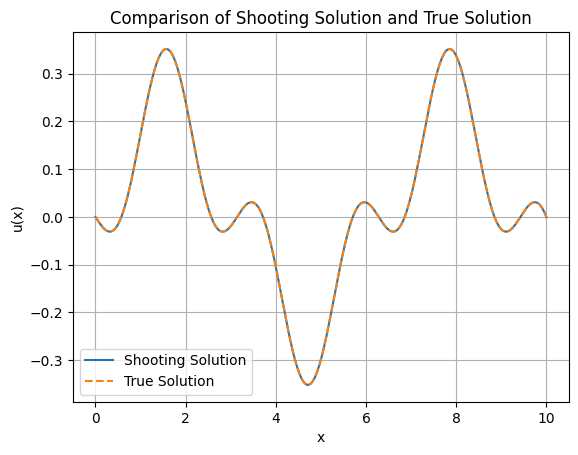

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

def f(x, v):
    u, v_ = v
    return np.array([v_, np.sin(3 * x) - u])

L = 10
N = 200
x = np.linspace(0, L, N)

u_a = [0, 0]
u_b = [0, 0]
i_a = 0
i_b = 0

# Solve the BVP using shooting method
u_sol, v_shoot = shoot_bvp(f, x, u_a, u_b, i_a, i_b)

# Calculate true solution
u_true_vals = u_true(x, L)

# Plot the solutions
plt.plot(x, u_sol, label="Shooting Solution")
plt.plot(x, u_true_vals, label="True Solution", linestyle='--')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.title('Comparison of Shooting Solution and True Solution')
plt.grid(True)
plt.show()


The following cell tests your shooting code against the true solution.  Adjust the relative and absolute tolerances in shoot_bvp, to make sure the following test passes with relative error $<10^{-6}$

In [15]:
#  test the solution against the true solution and pass if relative error < 1.e-6

rel_err = numpy.linalg.norm(u_sol - u_true(x,L))/numpy.linalg.norm(u_true(x,L))
print('relative error = {}'.format(rel_err))

assert(rel_err < 1.e-6)
print('success')

relative error = 8.941266927467626e-07
success


rtol=1.e-7, atol=1.e-9

**(d)** [8] Repeat the exercise but use the 2nd order finite difference methods introduced in class.  For convenience I have provided the routines for assembly of sparse 2nd derivative matrices and RHS from class.  

In [18]:

from fdcoeffV import fdcoeffV
from scipy.sparse import lil_matrix, identity, spdiags
from scipy.sparse.linalg import spsolve

def D2(x,bcs=['dirichlet', 'dirichlet']):
    """  
        Assemble a general sparse second-order finite-difference approximation to d/dx^2 on a possibly irregular mesh
        First and last rows are set by string bcs
        
        parameters:
        -----------
        x: numpy.array
            mesh coordinates
        bcs: list of strings for boundary conditions e.g [left_string, right_string] where
            the strings can be either 'dirichlet' or 'neumann'
    """
    N = len(x)
    A = lil_matrix((N,N))
    if bcs[0] == 'dirichlet':
        A[0,0] = 1.
    elif bcs[0] == 'neumann':
        A[0,0:3] = fdcoeffV(1,x[0],x[:3])
    else:
        raise ValueError('no known BC type for left boundary {}'.format(bcs[0]))
        
    if bcs[1] == 'dirichlet':
        A[-1,-1] = 1.
    elif bcs[1] == 'neumann':
        A[-1,-3:] = fdcoeffV(1,x[-1],x[-3:])
    else:
        raise ValueError('no known BC type for right boundary {}'.format(bcs[1]))
        
    for i in range(1,N-1):
        A[i, i-1:i+2] = fdcoeffV(2, x[i], x[i-1:i+2] )        
    return A.tocsr()

def RHS(x, f, bvalues):
    """ Set the rhs vector
    
        parameters
        ----------
        x: numpy.array
            mesh coordinates
        f: callable
            rhs function for interior points called on f(x[1:-2])
        bvalues:  numpy.array (len 2)
            values for boundary conditions (either dirichlet or neumann)        
    """
    
    N = len(x)
    rhs = numpy.empty(N)
    rhs[[0, N-1]] = bvalues
    rhs[1:-1] = f(x[1:-1])
    
    return rhs
    

Create a well-labeled convergence plot showing the relative error 

$$
    e_{rel} = \frac{|| u - u_{true} ||}{||u_{true}||}
$$

as a function of grid spacing $\Delta x$

This plot should calculate and show

* rate of convergence of error (i.e. find $p$ such that $e_{rel}\propto \Delta x^p$)
* an estimate of the  number of grid points $N$ required for the relative error to be $\leq 10^{-6}$
* the relative error at this smallest mesh spacing

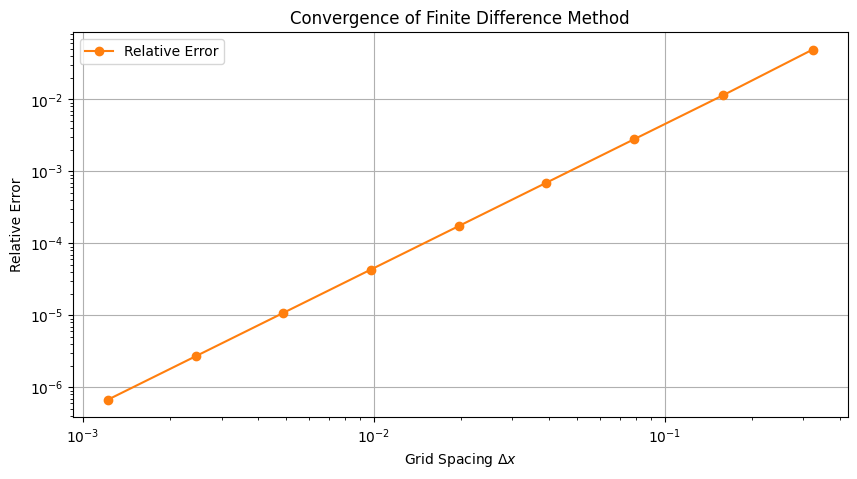

Estimated rate of convergence: 2.00
Smallest number of grid points (N) for relative error <= 10^-6: 8192
Relative error at this smallest mesh spacing: 6.76e-07


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def u_true(x, L):
    coeff = np.sin(3 * L) / (8 * np.sin(L))
    return coeff * np.sin(x) - (1 / 8) * np.sin(3 * x)

def f(x):
    return np.sin(3 * x)

L = 10
N_values = [2**n for n in range(5, 14)]
errors = []
dx_values = []

for N in N_values:
    x = np.linspace(0, L, N)
    dx = x[1] - x[0]
    dx_values.append(dx)

    diagonals = [
        np.ones(N - 1) / dx**2,
        -2 * np.ones(N) / dx**2 + 1,
        np.ones(N - 1) / dx**2
    ]
    A = diags(diagonals, offsets=[-1, 0, 1], format="csr")

    A[0, 0] = 1.0
    A[0, 1] = 0.0
    A[-1, -1] = 1.0
    A[-1, -2] = 0.0

    b = f(x)
    b[0] = 0
    b[-1] = 0

    u_fd = spsolve(A, b)

    u_exact = u_true(x, L)

    error = np.linalg.norm(u_fd - u_exact, np.inf) / np.linalg.norm(u_exact, np.inf)
    errors.append(error)

for dx, error, N in zip(dx_values, errors, N_values):
    if error <= 1e-6:
        smallest_dx = dx
        smallest_error = error
        smallest_N = N
        break

plt.figure(figsize=(10, 5))
plt.loglog(dx_values, errors, '-o', label='Relative Error', color='tab:orange')
plt.xlabel(r'Grid Spacing $\Delta x$')
plt.ylabel('Relative Error')
plt.title('Convergence of Finite Difference Method')
plt.legend()
plt.grid(True)
plt.show()

rate_of_convergence, intercept = np.polyfit(np.log(dx_values), np.log(errors), 1)
print(f"Estimated rate of convergence: {rate_of_convergence:.2f}")
print(f"Smallest number of grid points (N) for relative error <= 10^-6: {smallest_N}")
print(f"Relative error at this smallest mesh spacing: {smallest_error:.2e}")


In [21]:
from tabulate import tabulate

data = [
    ["Rate of Convergence", f"{rate_of_convergence:.2f}"],
    ["Smallest N for error <= 10^-6", f"{smallest_N}"],
    ["Relative error at smallest mesh spacing", f"{smallest_error:.2e}"]
]

headers = ["Metric", "Value"]
print(tabulate(data, headers=headers, tablefmt="pretty"))


+-----------------------------------------+----------+
|                 Metric                  |  Value   |
+-----------------------------------------+----------+
|           Rate of Convergence           |   2.00   |
|      Smallest N for error <= 10^-6      |   8192   |
| Relative error at smallest mesh spacing | 6.76e-07 |
+-----------------------------------------+----------+


### Some themes and variations

This is meant to be a short problem set, but there are many other things to try if you are interested.

* Try this problem using Galerkin Finite Elements.  
* Try modifying the matrices to use higher order Finite difference schemes (i.e. 4th order schemes)
* Compare timing between Finite Difference and shooting schemes for the same order of accuracy


## Question 2 - Non-Linear Fun

try to solve the related  **non-linear** 2-point boundary value problem

$$
u^{\prime\prime}+\sin(u)=\sin(3x),\quad x\in[0,10],\quad u(0)=u(10)=0
$$

using  finite-difference plus Newton's method. For convenience, I've added the Newton Solver for sparse jacobians from the notes

In [24]:
# a Newton Solver for sparse matrices
def newton(F,J,x0,tol=1.e-6,MAX_ITS=100,verbose=True):
    """ Solve F(x) = 0 using Newton's method until ||F(x)|| < tol or reaches Max iterations
    
    Params:
    -------
        F: calleable: 
            Function returning residual F(x)
        J: calleable
            Function returning Jacobian J(x)
        tol: float
            stopping criteria for ||F|| < tol
        MAX_ITS: integer
            maximum number of iterations
        verbose: bool
            if true spits out norm of the residual at each iteration
            
    Returns:
    --------
        x: numpy.array
            solution
        k: int
            number of iterations
    
    Raises:
    -----------
        ValueError if number of its exceeds MAX_ITS
        
    """
    x = x0 
    for k in range(MAX_ITS+1):
        res = numpy.linalg.norm(F(x))
        if verbose:
            print('k = {}, ||F|| = {}'.format(k,res))
        if res < tol: 
            return x, k
        delta = spsolve(J(x),-F(x))
        x += delta
        
    raise ValueError('Maximum number of iterations exceeded {}'.format(MAX_ITS))

**(a)** [4 pt]  Solve the problem for an initial guess
$u_0=0$. For this problem you will need to

* create a function to return the residual $\mathbf{F}(\mathbf{u})$
* create a function to return the Jacobian $J(\mathbf{u})$
* use `verbose=True` to see the convergence behavior of Newton
* produce a plot showing the solution and labeled with the number of newton iterations and final residual norm $||\mathbf{F}(\mathbf{u})||$

**Note:**  To choose a reasonable number of grid points, use your results from Question 1 and choose a mesh size such that the linear problem returns a relative error $< 10^{-3}$

k = 0, ||F|| = 9.975647311061403
k = 1, ||F|| = 0.040066871833903006
k = 2, ||F|| = 0.0011390847101189717
k = 3, ||F|| = 1.5434914620197893e-06
k = 4, ||F|| = 2.9944047170980488e-12


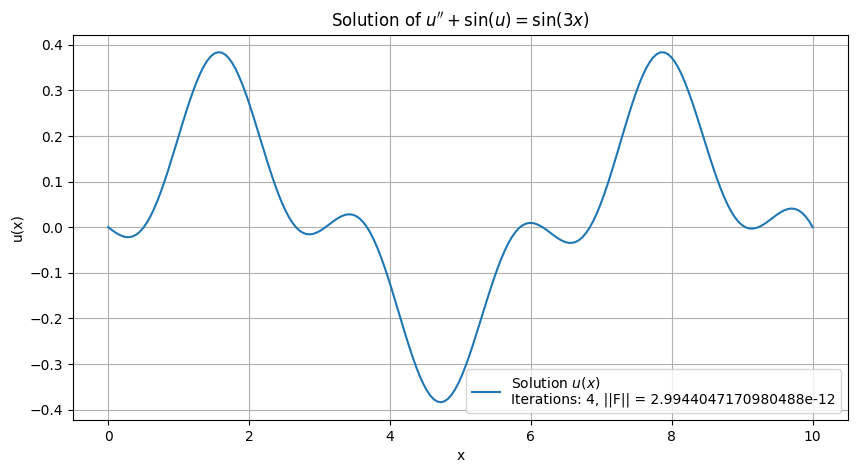

In [26]:
N = 200
x = numpy.linspace(0, 10, N)
h = x[1] - x[0]

A = D2(x, bcs=['dirichlet', 'dirichlet'])

def non_linear_term(u):
    return numpy.sin(u)

def right_hand_side(x):
    return numpy.sin(3 * x)

bvalues = numpy.array([0, 0])
rhs = RHS(x, right_hand_side, bvalues)

def F(u):
    return A.dot(u) + non_linear_term(u) - rhs

def J(u):
    diagonal = numpy.cos(u)
    J_matrix = A.copy()
    J_matrix.setdiag(diagonal + J_matrix.diagonal())
    return J_matrix

u0 = numpy.zeros(N)

def newton(F, J, x0, tol=1.e-6, MAX_ITS=100, verbose=True):
    x = x0.copy()
    for k in range(MAX_ITS+1):
        res = numpy.linalg.norm(F(x))
        if verbose:
            print('k = {}, ||F|| = {}'.format(k, res))
        if res < tol:
            return x, k
        delta = spsolve(J(x), -F(x))
        x += delta

    raise ValueError('Maximum number of iterations exceeded')

solution, num_iterations = newton(F, J, u0, verbose=True)

plt.figure(figsize=(10, 5))
plt.plot(x, solution, label=f'Solution $u(x)$\nIterations: {num_iterations}, ||F|| = {numpy.linalg.norm(F(solution))}')
plt.title(r"Solution of $u'' + \sin(u) = \sin(3x)$")
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.grid(True)
plt.show()


**(b)**  Is your solution unique?  Try starting newton from different
  periodic initial conditions 
  
  $$
      u_0(x) = \sin\left[\frac{n\pi x}{L}\right]
  $$ 
  
  for $n\in[0,6]$ that all satisfy the homogeneous boundary conditions. 
  
  Make two plots. 
  
  1. The first shows solutions for different values of $n$
  1. The second plots the residual $\mathbf{F}(\mathbf{u})$ to show that at least the discrete ODE is satisfied
  
 Welcome to the wonderful world of non-linear equations. Can you find any other solutions?

k = 0, ||F|| = 9.975647311061403
k = 1, ||F|| = 0.040066871833903006
k = 2, ||F|| = 0.0011390847101189717
k = 3, ||F|| = 1.5434914620197893e-06
k = 4, ||F|| = 2.9944047170980488e-12
k = 0, ||F|| = 12.615463299668619
k = 1, ||F|| = 2.0439586299425163
k = 2, ||F|| = 0.18654333489528588
k = 3, ||F|| = 0.006611195165854884
k = 4, ||F|| = 1.6250787156978097e-05
k = 5, ||F|| = 1.093271167965434e-10
k = 0, ||F|| = 11.178671459419439
k = 1, ||F|| = 4.711169206133537
k = 2, ||F|| = 2.4375073125285533
k = 3, ||F|| = 0.4403068639452186
k = 4, ||F|| = 0.044543240252007975
k = 5, ||F|| = 0.0007078169659834359
k = 6, ||F|| = 2.114481352917056e-07
k = 0, ||F|| = 9.766727086672503
k = 1, ||F|| = 0.14770565274935962
k = 2, ||F|| = 0.014730589706871291
k = 3, ||F|| = 0.0003911784527743014
k = 4, ||F|| = 3.225375700166926e-07
k = 0, ||F|| = 11.934795789806303
k = 1, ||F|| = 1.516007559300816
k = 2, ||F|| = 0.2932945292683538
k = 3, ||F|| = 0.04669355149621178
k = 4, ||F|| = 0.002002547309194575
k = 5, ||

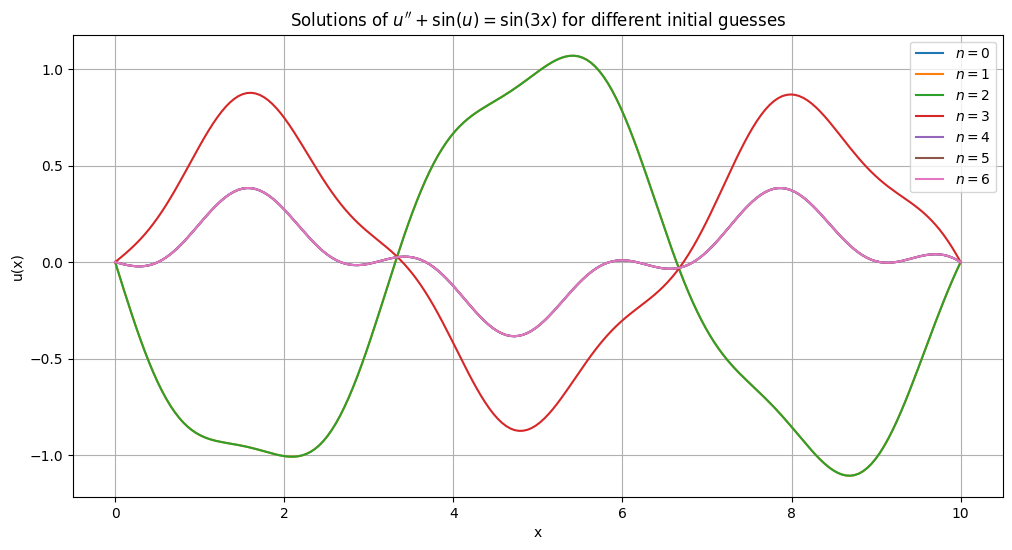

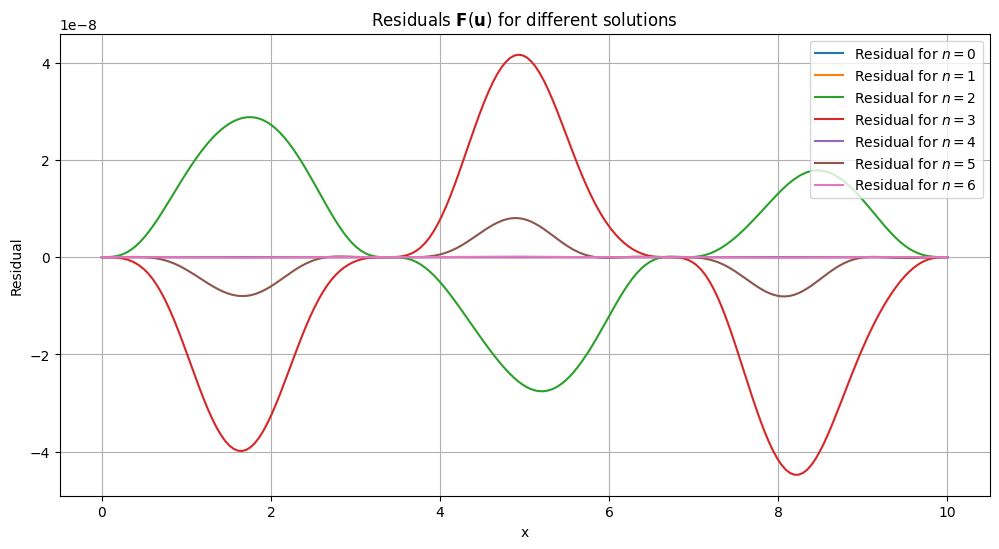

In [54]:
n_values = range(7)
solutions = []
residuals = []
iteration_data = []

for n in n_values:
    u0 = numpy.sin(n * numpy.pi * x / L)
    u0[0] = 0
    u0[-1] = 0
    
    try:
        solution, num_iterations = newton(F, J, u0, verbose=True)
        solutions.append(solution)
        residuals.append(F(solution))
        iteration_data.append({'n': n, 'Iterations': num_iterations, 'Final Residual Norm': numpy.linalg.norm(F(solution))})
    except ValueError as e:
        iteration_data.append({'n': n, 'Iterations': 'Failed', 'Final Residual Norm': 'Failed'})

from tabulate import tabulate

# Plotting solutions
plt.figure(figsize=(12, 6))
for i, solution in enumerate(solutions):
    plt.plot(x, solution, label=f'$n={n_values[i]}$')
plt.title(r"Solutions of $u'' + \sin(u) = \sin(3x)$ for different initial guesses")
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting residuals
plt.figure(figsize=(12, 6))
for i, residual in enumerate(residuals):
    plt.plot(x, residual, label=f'Residual for $n={n_values[i]}$')
plt.title(r"Residuals $\mathbf{F}(\mathbf{u})$ for different solutions")
plt.xlabel('x')
plt.ylabel('Residual')
plt.legend()
plt.grid(True)
plt.show()


In [56]:
print(tabulate(iteration_data, headers="keys", tablefmt="grid"))


+-----+--------------+-----------------------+
|   n |   Iterations |   Final Residual Norm |
+=====+==============+=======================+
|   0 |            4 |           2.9944e-12  |
+-----+--------------+-----------------------+
|   1 |            5 |           1.09327e-10 |
+-----+--------------+-----------------------+
|   2 |            6 |           2.11448e-07 |
+-----+--------------+-----------------------+
|   3 |            4 |           3.22538e-07 |
+-----+--------------+-----------------------+
|   4 |            6 |           2.6904e-11  |
+-----+--------------+-----------------------+
|   5 |            4 |           5.3394e-08  |
+-----+--------------+-----------------------+
|   6 |            4 |           8.0922e-10  |
+-----+--------------+-----------------------+


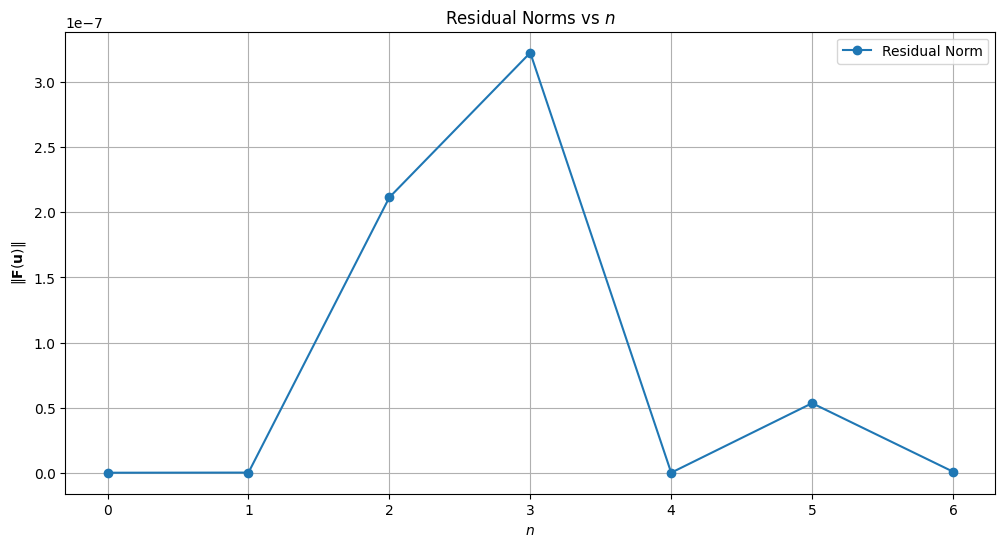

In [58]:
residual_norms = [
    numpy.linalg.norm(residual) if isinstance(residual, numpy.ndarray) else None
    for residual in residuals
]
plt.figure(figsize=(12, 6))
plt.plot(n_values, residual_norms, marker='o', linestyle='-', label='Residual Norm')
plt.title(r"Residual Norms vs $n$")
plt.xlabel(r"$n$")
plt.ylabel(r"$\|\mathbf{F}(\mathbf{u})\|$")
plt.grid(True)
plt.legend()
plt.show()

### Extra Fun

Use your shooting routines to systematically search for non-linear solutions to this BVP problem by varying the initial guess for the initial slope $u'(0)$. How many solutions can you find?

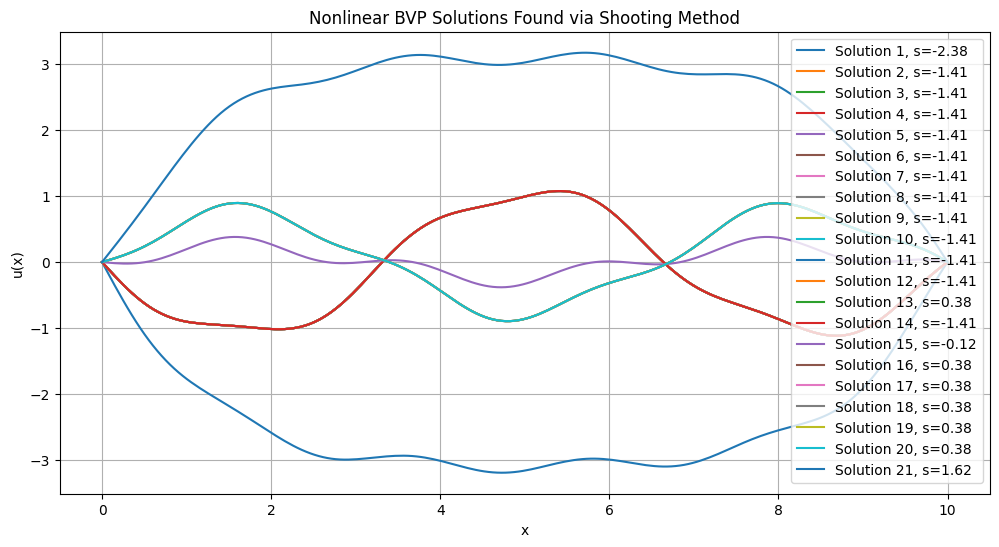

Number of solutions found: 21


In [33]:
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar

def bvp_system(x, y):
    u, du = y
    d2u = -numpy.sin(u) + numpy.sin(3 * x)
    return [du, d2u]

def shooting_residual(s):
    sol = solve_ivp(bvp_system, [0, L], [0, s], t_eval=[L])
    return sol.y[0, -1]  # Residual u(L) - 0

L = 10
initial_slopes = numpy.linspace(-5, 5, 100)
solutions = []

for s in initial_slopes:
    try:
        # Use root-finding to refine the initial guess
        result = root_scalar(shooting_residual, bracket=[s - 1, s + 1], method='brentq')
        if result.converged:
            sol = solve_ivp(bvp_system, [0, L], [0, result.root], t_eval=numpy.linspace(0, L, 200))
            solutions.append((result.root, sol.y[0]))
    except ValueError:
        continue

plt.figure(figsize=(12, 6))
for i, (s, solution) in enumerate(solutions):
    plt.plot(numpy.linspace(0, L, 200), solution, label=f'Solution {i+1}, s={s:.2f}')
plt.title("Nonlinear BVP Solutions Found via Shooting Method")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Number of solutions found: {len(solutions)}")
